In [3]:
# Code author: Kushanav Bhuyan and Lorenzo Nava

import tensorflow as tf
from tensorflow.keras.layers import Input

import tensorflow.keras as keras
import segmentation_models as sm

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.python.keras import backend as K

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from unet import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.pyplot as plt

In [4]:
# Load the arrays of your training data

X_train = np.load("Arrays/Train/X_train.npy")
Y_train = np.load("Arrays/Train/Y_train.npy")

X_test = np.load("Arrays/Test/X_test_2017.npy")
Y_test = np.load("Arrays/Test/Y_test_2017.npy")

In [5]:
print(f"Shapes: {X_train.shape}")
print(f"Shapes: {Y_train.shape}")
print(f"Shapes: {X_test.shape}")
print(f"Shapes: {Y_test.shape}")

Shapes: (172, 128, 128, 5)
Shapes: (172, 128, 128, 1)
Shapes: (35, 128, 128, 5)
Shapes: (35, 128, 128, 1)


Text(0.5, 1.0, 'Landslide mask')

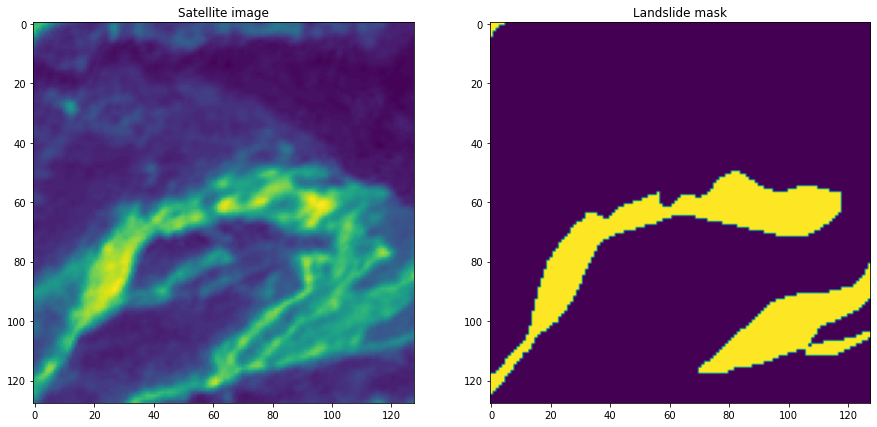

In [17]:
# Visualise
no = 51

f, axarr = plt.subplots(1,2, figsize=(15,15))

axarr[0].imshow(X_train[no,:,:,2])
axarr[0].set_title("Satellite image")

axarr[1].imshow(Y_train[no])
axarr[1].set_title("Landslide mask")

In [4]:
# Tversky Loss Function

def tversky(y_true, y_pred, alpha=0.15, beta=0.85):
  
    """
    Function to calculate the Tversky loss for imbalanced data
    :param prediction: the logits
    :param ground_truth: the segmentation ground_truth
    :param alpha: weight of false positives
    :param beta: weight of false negatives
    :param weight_map:
    :return: the loss
    """
    '''
    EPSILON = 0.00001 (default)
    '''
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    # TP
    true_pos = K.sum(y_true_pos * y_pred_pos)
    # FN
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    # FP
    false_pos = K.sum((1-y_true_pos) * y_pred_pos)
    return 1 - (true_pos + K.epsilon())/(true_pos + alpha * false_neg + beta * false_pos + K.epsilon())

In [5]:
# Define the evaluation metrics - Precision, Recall, FScore, IoU
metrics_sm = [sm.metrics.Precision(threshold=0.5),sm.metrics.Recall(threshold=0.5),sm.metrics.FScore(threshold=0.5,beta=1),sm.metrics.IOUScore(threshold=0.5)]

In [6]:
# Callback to dynamically reduce the learning rate on plateaus
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=20, min_lr=0.00001,verbose=1)

In [7]:
PATCHSIZE = 128
NBANDS = 5
loss = tversky
opt = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')

In [8]:
# U-Net model 

def UNet(filters, pretrained_weights = None, input_size = (PATCHSIZE, PATCHSIZE, NBANDS)):
  
    inputs = Input(input_size)
    conv1_1 = Conv2D(filters, (3, 3), padding='same')(inputs)
    bn1_1 = BatchNormalization(axis=3)(conv1_1)
    relu1_1 = Activation('relu')(bn1_1)
    conv1_2 = Conv2D(filters, (3, 3), padding='same')(relu1_1)
    bn1_2 = BatchNormalization(axis=3)(conv1_2)
    relu1_2 = Activation('relu')(bn1_2)
    pool1 = MaxPooling2D(pool_size=(2, 2))(relu1_2)
    
    conv2_1 = Conv2D(filters*2, (3, 3), padding='same')(pool1)
    bn2_1 = BatchNormalization(axis=3)(conv2_1)
    relu2_1 = Activation('relu')(bn2_1)
    conv2_2 = Conv2D(filters*2, (3, 3), padding='same')(relu2_1)
    bn2_2 = BatchNormalization(axis=3)(conv2_2)
    relu2_2 = Activation('relu')(bn2_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(relu2_2)
    
    conv3_1 = Conv2D(filters*4, (3, 3), padding='same')(pool2)
    bn3_1 = BatchNormalization(axis=3)(conv3_1)
    relu3_1 = Activation('relu')(bn3_1)
    conv3_2 = Conv2D(filters*4, (3, 3), padding='same')(relu3_1)
    bn3_2 = BatchNormalization(axis=3)(conv3_2)
    relu3_2 = Activation('relu')(bn3_2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(relu3_2)
    
    conv4_1 = Conv2D(filters*8, (3, 3), padding='same')(pool3)
    bn4_1 = BatchNormalization(axis=3)(conv4_1)
    relu4_1 = Activation('relu')(bn4_1)
    conv4_2 = Conv2D(filters*8, (3, 3), padding='same')(relu4_1)
    bn4_2 = BatchNormalization(axis=3)(conv4_2)
    relu4_2 = Activation('relu')(bn4_2)
    pool4 = MaxPooling2D(pool_size=(2, 2))(relu4_2)
    
    conv5_1 = Conv2D(filters*16, (3, 3), padding='same')(pool4)
    bn5_1 = BatchNormalization(axis=3)(conv5_1)
    relu5_1 = Activation('relu')(bn5_1)
    conv5_2 = Conv2D(filters*16, (3, 3), padding='same')(relu5_1)
    bn5_2 = BatchNormalization(axis=3)(conv5_2)
    relu5_2 = Activation('relu')(bn5_2)
    
    up6 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(relu5_2), relu4_2])
    conv6_1 = Conv2D(filters*8, (3, 3), padding='same')(up6)
    bn6_1 = BatchNormalization(axis=3)(conv6_1)
    relu6_1 = Activation('relu')(bn6_1)
    conv6_2 = Conv2D(filters*8, (3, 3), padding='same')(relu6_1)
    bn6_2 = BatchNormalization(axis=3)(conv6_2)
    relu6_2 = Activation('relu')(bn6_2)
    
    up7 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(relu6_2), relu3_2])
    conv7_1 = Conv2D(filters*4, (3, 3), padding='same')(up7)
    bn7_1 = BatchNormalization(axis=3)(conv7_1)
    relu7_1 = Activation('relu')(bn7_1)
    conv7_2 = Conv2D(filters*4, (3, 3), padding='same')(relu7_1)
    bn7_2 = BatchNormalization(axis=3)(conv7_2)
    relu7_2 = Activation('relu')(bn7_2)
    
    up8 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(relu7_2), relu2_2])
    conv8_1 = Conv2D(filters*2, (3, 3), padding='same')(up8)
    bn8_1 = BatchNormalization(axis=3)(conv8_1)
    relu8_1 = Activation('relu')(bn8_1)
    conv8_2 = Conv2D(filters*2, (3, 3), padding='same')(relu8_1)
    bn8_2 = BatchNormalization(axis=3)(conv8_2)
    relu8_2 = Activation('relu')(bn8_2)
    
    up9 = Concatenate()([Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(relu8_2), relu1_2])
    conv9_1 = Conv2D(filters, (3, 3), padding='same')(up9)
    bn9_1 = BatchNormalization(axis=3)(conv9_1)
    relu9_1 = Activation('relu')(bn9_1)
    conv9_2 = Conv2D(filters, (3, 3), padding='same')(relu9_1)
    bn9_2 = BatchNormalization(axis=3)(conv9_2)
    relu9_2 = Activation('relu')(bn9_2)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(relu9_2)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam'), 
                  loss=loss, 
                  metrics=metrics_sm)

    print(model.summary())

    if(pretrained_weights):
        model.load_weights(pretrained_weights)
          
    return model

In [ ]:
epochs = 50

# Hyper-parameter combinations
HYPERPARAMETERS = {"lr":[1e-3,1e-4,1e-5],
                  "batch_size":[8],
                  "filters":[8,16,32],
                  }
# Dictionary to save the results
results = {"batch_size":[],
           "lr":[],
           "filters":[],
           "precision":[],
           "recall":[],
           "f1_score":[],
           "mIoU":[]}

# Loops
   
for filters in HYPERPARAMETERS["filters"]:

    for lr in HYPERPARAMETERS["lr"]:
    
        for batch_size in HYPERPARAMETERS["batch_size"]:
            
            save_path = f'Multi-Temporal/Data/Nepal/results/weights'
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            
            tf.keras.backend.clear_session()
#                     reset_keras()
            model = UNet(filters, opt=opt, input_size=(PATCHSIZE, PATCHSIZE, NBANDS), lossfxn=loss)

            # model = UNet(filters, pretrained_weights = None, input_size = (PATCHSIZE, PATCHSIZE, NBANDS))
            
            checkpoint = f'{save_path}/filters_{filters}_batch_size_{batch_size}_lr_{lr}.hdf5'
            
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_loss', mode='min',verbose=1, save_best_only=True,save_weights_only = True)
            
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
            
            history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,validation_split=0.1,callbacks = [model_checkpoint, early_stopping,reduce_lr])
            
            saveHistPlot(history=history, savePath=f"Multi-Temporal/Data/Nepal/results/plots", 
                            saveName=f"filters_{filters}_batch_size_{batch_size}_lr_{lr}.png")

             ################## evaluation ##################
                    
            tf.keras.backend.clear_session()
            resultModel = UNet(filters, opt=opt, input_size=(PATCHSIZE, PATCHSIZE, NBANDS), lossfxn=loss) # UNet(filters, pretrained_weights = None, input_size = (PATCHSIZE, PATCHSIZE, NBANDS))

            resultModel.load_weights(checkpoint)
            
            recall, precision, f1, iou = [],[],[],[]
            with tf.device('/cpu:0'):
                for ix in range(X_test.shape[0]):
                    result = resultModel.evaluate(np.expand_dims(X_test[ix],axis = 0),np.expand_dims(Y_test[ix],axis = 0))
                    precision.append(result[1])
                    recall.append(result[2])
                    f1.append(result[3])
                    iou.append(result[4])

                precision = np.array(precision).sum()/len(precision)
                recall = np.array(recall).sum()/len(recall)
                f1 = np.array(f1).sum()/len(f1)
                iou = np.array(iou).sum()/len(iou)
            
            ################## save the results ###################
            
            results["batch_size"].append(batch_size)
            results["lr"].append(lr)
            results["filters"].append(filters)
            results["precision"].append(precision)
            results["recall"].append(recall)
            results["f1_score"].append(f1)
            results["mIoU"].append(iou)
            
            # Convert results to a dataframe
            results_df = pd.DataFrame(results)
            # Export as csv
            save_path_results = f'Multi-Temporal/Data/Nepal/results/csv/results'
            if not os.path.exists(save_path_results):
                os.makedirs(save_path_results)
            results_df.to_csv(f'{save_path_results}/filters_{filters}_batch_size_{batch_size}_lr_{lr}.csv', index = False)
#                     cuda.select_device(0)
#                     cuda.close()
            tf.compat.v1.reset_default_graph()

In [ ]:
# load the best model
model_2 = UNet("unet_dropout",lr = 0.01, filtersFirstLayer=16, inputSize=(1024,1024,7))
model_2.load_weights("...../weights.hdf5") # Locate the weights after model training

In [ ]:
# plot the results
import matplotlib.pyplot as plt
for i in range(X_test.shape[0]):
    with tf.device('/cpu:0'):
        model_2.evaluate(np.expand_dims(X_test[i],axis = 0),np.expand_dims(Y_test[i],axis = 0))
        preds_train_1 = model_2.predict(np.expand_dims(X_test[i],axis = 0), verbose=1)
    preds_train_t1 = (preds_train_1 > 0.3).astype(np.uint8)
    f, axarr = plt.subplots(1,3,figsize=(10,10))
    axarr[0].imshow(X_test[i][:,:,:3])
    axarr[1].imshow(np.squeeze(preds_train_t1))
    axarr[2].imshow(np.squeeze(Y_test[i]))